In [94]:
import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import tensorflow
import matplotlib.pyplot as plt
# import dlib
# from dlib import get_landmarks()
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import cv2

In [6]:
df= pd.read_csv('fer2013.csv')

In [7]:
# df.info()
df
# np.unique(np.array(df.head()))
print(df['Usage'].value_counts())
print(df['emotion'].value_counts())
# df1 = df[df.Usage!='PrivateTest']
df2 = df[(df["emotion"]!=1) & (df["emotion"]!=2)]
df2["emotion"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


3    8989
6    6198
4    6077
0    4953
5    4002
Name: emotion, dtype: int64

In [101]:
df2.loc[df2.emotion==5,"emotion"] = 1
df2.loc[df2.emotion==6,"emotion"] = 2
df2["emotion"].value_counts()
# df2
# df2.drop(['Usage'],axis = 1)
# help(df2.drop)
traindf = df2[df2["Usage"]=='Training'].drop(['Usage'],axis=1).reset_index()
devdf = df2[df2["Usage"]=='PublicTest'].drop(['Usage'],axis=1).reset_index()
testdf = df2[df2["Usage"]=='PrivateTest'].drop(['Usage'],axis=1).reset_index()
print(testdf["emotion"].value_counts(),"\n...\n",devdf["emotion"].value_counts(),"\n...\n",traindf["emotion"].value_counts())
# traindf.head(20)
# testdf
# print(devdf.head(1))
# print(testdf.head(1))

3    879
2    626
4    594
0    491
1    416
Name: emotion, dtype: int64 
...
 3    895
4    653
2    607
0    467
1    415
Name: emotion, dtype: int64 
...
 3    7215
2    4965
4    4830
0    3995
1    3171
Name: emotion, dtype: int64


C:\ANACONDA3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [130]:
expression = ["angry","surprise","neutral","happy","sad"]
ferheight,ferwidth = 48,48
def show_img(index,data):
    """Shows the image and the emotion label of the index's instance."""
    image = np.reshape(data.at[index, "pixels"].split(" "), 
                       (ferheight,ferwidth)).astype("float")
    image -= np.mean(image)
    image /= np.std(image)
    print("actual \t\t=",data.loc[index,"emotion"],expression[data.loc[index,"emotion"]])
    plt.imshow(image, cmap="gray")
    plt.show()

In [10]:
def Process(df,X,y):
    for i,row in df.iterrows():
#         if(i<=20):
#             print("nn\n",row['pixels'])
        X.append(np.array(row['pixels'].split(" ")))
        y.append(row['emotion'])
    X,y = np.array(X,'float32'), np.array(y,'float32')
#     print(X[0])
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
#     print(X[0])

In [11]:
X_train,y_train = [],[]
Process(traindf,X_train,y_train)
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape,y_train.shape)

(24176, 2304) (24176,)


In [12]:
X_dev,y_dev = [],[]
Process(devdf,X_dev,y_dev)
X_dev = np.array(X_dev)
y_dev = np.array(y_dev)
print(X_dev.shape,y_dev.shape)

(3037, 2304) (3037,)


In [13]:
X_test,y_test = [],[]
Process(testdf,X_test,y_test)
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape,y_test.shape)

(3006, 2304) (3006,)


In [14]:
y_train1=np_utils.to_categorical(y_train, num_classes=5)
y_dev1=np_utils.to_categorical(y_dev, num_classes=5)
y_test1=np_utils.to_categorical(y_test, num_classes=5)
print(y_train1.shape,y_dev1.shape,y_test1.shape)

(24176, 5) (3037, 5) (3006, 5)


In [15]:
X_train,X_test,X_dev = X_train.reshape(X_train.shape[0],ferheight,ferwidth,1),X_test.reshape(X_test.shape[0],ferheight,ferwidth,1),X_dev.reshape(X_dev.shape[0],ferheight,ferwidth,1)

In [16]:
print(X_train.shape,y_train.shape)
print(X_dev.shape,y_dev.shape)
print(X_test.shape,y_test.shape)

(24176, 48, 48, 1) (24176,)
(3037, 48, 48, 1) (3037,)
(3006, 48, 48, 1) (3006,)


In [17]:
nfeatures = 64
nlabels = 5
batch_size = 32
epochs = 30

In [18]:
model = keras.models.Sequential()

model.add(Conv2D(nfeatures,kernel_size = (3,3),activation = 'elu', input_shape = (ferheight,ferwidth,1) ))
model.add(Conv2D(nfeatures,kernel_size = (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))


model.add(Conv2D(2*nfeatures,kernel_size = (3,3),activation = 'relu'))
model.add(Conv2D(2*nfeatures,kernel_size = (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))


model.add(Conv2D(4*nfeatures,kernel_size = (3,3),activation = 'relu'))
model.add(Conv2D(4*nfeatures,kernel_size = (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Flatten())


model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nlabels, activation='softmax'))

In [24]:
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])

model_info = model.fit(X_train,y_train1, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_dev, y_dev1), shuffle=True)
model.save_weights('model.h5')

Train on 24176 samples, validate on 3037 samples
Epoch 1/30
24176/24176 [==============================] - 435s 18ms/step - loss: 1.7169 - accuracy: 0.3160 - val_loss: 1.4389 - val_accuracy: 0.3823
Epoch 2/30
24176/24176 [==============================] - 377s 16ms/step - loss: 1.4197 - accuracy: 0.3815 - val_loss: 1.3676 - val_accuracy: 0.4215
Epoch 3/30
24176/24176 [==============================] - 370s 15ms/step - loss: 1.3477 - accuracy: 0.4284 - val_loss: 1.3214 - val_accuracy: 0.4699
Epoch 4/30
24176/24176 [==============================] - 372s 15ms/step - loss: 1.3004 - accuracy: 0.4568 - val_loss: 1.3079 - val_accuracy: 0.4524
Epoch 5/30
24176/24176 [==============================] - 376s 16ms/step - loss: 1.2693 - accuracy: 0.4671 - val_loss: 1.2456 - val_accuracy: 0.4979
Epoch 6/30
24176/24176 [==============================] - 1016s 42ms/step - loss: 1.2344 - accuracy: 0.4920 - val_loss: 1.2338 - val_accuracy: 0.4936
Epoch 7/30
24176/24176 [==============================] 

In [25]:
# plot_model_history(model_info)


In [21]:
model.load_weights('model.h5')

In [103]:
cap = cv2.VideoCapture(0)
while(True):
    ret,frame = cap.read()
#     if not ret:
#         break
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y-25), (x+w, y+h+10), (0, 255, 0), 2)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img)
        maxindex = int(np.argmax(prediction))
        cv2.putText(frame, expression[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

    cv2.imshow('Video', cv2.resize(frame,(1600,960),interpolation = cv2.INTER_CUBIC))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [99]:
y_pred = model.predict(X_test)
test_prediction = []
for i in y_pred:
    pos = np.where(i == np.amax(i))
    test_prediction.append(pos[0][0])
    i = [1 if j==pos[0] else 0 for j in range(len(i))]
test_prediction = np.array(test_prediction)

print("accuracy on unseen test data is : ",accuracy_score(y_test,test_prediction))
print("Classification report : ",classification_report(y_test,test_prediction))
print("confusion matrix : \n",confusion_matrix(y_test,test_prediction))

accuracy on unseen test data is :  0.5319361277445109
Classification report :                precision    recall  f1-score   support

           0       0.54      0.28      0.37       491
           1       0.94      0.41      0.57       416
           2       0.39      0.64      0.48       626
           3       0.68      0.75      0.71       879
           4       0.41      0.40      0.40       594

    accuracy                           0.53      3006
   macro avg       0.59      0.49      0.51      3006
weighted avg       0.58      0.53      0.53      3006

confusion matrix : 
 [[137   4 159  87 104]
 [ 22 169 122  63  40]
 [ 32   1 398  80 115]
 [ 19   4 111 658  87]
 [ 43   1 233  80 237]]


index = 595
[0.11936586 0.02618299 0.45102915 0.25025228 0.15316972]
predicted	= 2 neutral
actual 		= 2 neutral


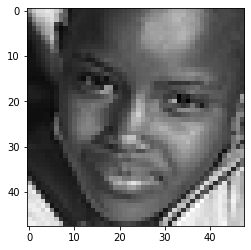

index = 742
[0.01935263 0.00819643 0.25498563 0.68005913 0.03740623]
predicted	= 3 happy
actual 		= 3 happy


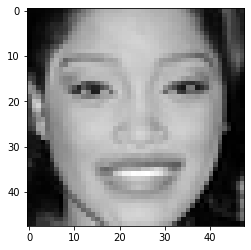

index = 1064
[0.38239223 0.01636454 0.05461269 0.23343912 0.31319144]
predicted	= 0 angry
actual 		= 3 happy


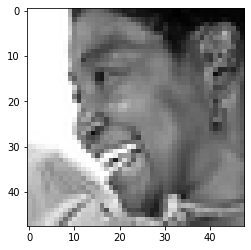

index = 1993
[0.08959824 0.00340111 0.16818652 0.6705041  0.06831001]
predicted	= 3 happy
actual 		= 0 angry


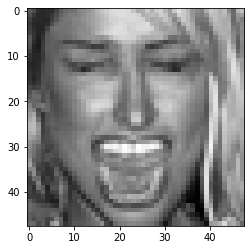

index = 2998
[0.03008704 0.00543815 0.08585458 0.86674434 0.01187599]
predicted	= 3 happy
actual 		= 2 neutral


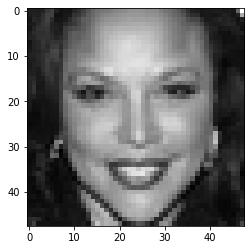

In [142]:
np.random.seed(23)
for i in range(5):
    index = np.random.randint(0,len(X_test))
    print("index =",index)
    pred = model.predict(X_test[index].reshape(1,ferheight,ferwidth,1))
    pred = np.squeeze(pred)
    print(pred)
    pos = np.where(pred == np.amax(pred))
    print('predicted\t=',pos[0][0],expression[pos[0][0]])
    show_img(index,testdf)
pred = model.predict(X_test[1].reshape(1,ferheight,ferwidth,1))
# show_img(0,devdf)

In [138]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)        